In [9]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import pickle
import nltk
import os

In [2]:
# Load our Players
checkpoint = '__checkpoints'
filename = 'reports_cleaned'

with open(os.path.join(checkpoint, filename + '.pkl'), 'rb') as f:
    df = pickle.load(f)
    
players = list(set(df['Player']))

### Classification using NFL Career Data

In [82]:
# Career NFL Data
path = 'dataset-quarterback_stats'
filename = 'nfl_2006-2021.csv'

nfl = pd.read_csv(os.path.join(path, filename))

In [83]:
nfl.head(3)

,Player,Years,Position,Race,Games,Games Started,Wins,Losses,Draws,Completions,...,4th Quarter Comeback,Game Winning Drives,Rushing Attempts,Rushing Yards,Rushing TDs,Rushing 1D,Longest Run,Rush Yds/Att,Rush Yds/Game,Fumbles
0,A.J. Feeley,3.00000,QB,White,10.00000,5.00000,1.00000,4.00000,0.00000,138.00000,...,0.00000,1.00000,11.00000,30.00000,0.00000,3.00000,7.00000,2.73000,3.00000,5.00000
1,A.J. McCarron,5.00000,QB,White,16.00000,4.00000,2.00000,2.00000,0.00000,109.00000,...,0.00000,0.00000,22.00000,68.00000,1.00000,6.00000,18.00000,3.09000,4.25000,2.00000
2,Aaron Brooks,1.00000,QB,Non-White,8.00000,8.00000,0.00000,8.00000,0.00000,110.00000,...,0.00000,0.00000,22.00000,124.00000,0.00000,5.00000,23.00000,5.64000,15.50000,5.00000


In [84]:
df0 = nfl[nfl['Player'].isin(players)].reset_index(drop=True)

In [85]:
# Split into Training and Test Data
X_train = df0.drop(['Player', 'Position', 'Race'], axis=1)
y_train = np.asarray(df0['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(136, 36)
(136,)


In [86]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.330065
         Iterations 9


In [87]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  136
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                           35
Date:                Thu, 02 Feb 2023   Pseudo R-squ.:                  0.4552
Time:                        21:45:35   Log-Likelihood:                -44.889
converged:                       True   LL-Null:                       -82.388
Covariance Type:            nonrobust   LLR p-value:                 9.791e-05
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Years                   -0.8148      0.351     -2.322      0.020      -1.503      -0.127
Games                    0.0796      0.071      1.125      0.261      -0.059       0.218
Games Starte

In [88]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']

# Convert log odds to Odds Ratios
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['P-Values'] = model.pvalues
odds['Significant?'] = ['Significant' if pval <= 0.05 else 'Not Significant' for pval in model.pvalues]
odds

,2.5%,97.5%,Odds Ratio,P-Values,Significant?
Years,0.22255,0.88082,0.44275,0.02026,Significant
Games,0.94262,1.24404,1.08289,0.26056,Not Significant
Games Started,0.04303,2.43653,0.32381,0.27348,Not Significant
Wins,0.42223,24.53814,3.21881,0.25932,Not Significant
Losses,0.28635,17.75390,2.25472,0.43999,Not Significant
Draws,0.29361,351.76137,10.16263,0.19975,Not Significant
Completions,0.90121,0.99176,0.94540,0.02151,Significant
Attempts,0.98566,1.04115,1.01303,0.35427,Not Significant
Cmp %,0.19095,7.91225,1.22917,0.82807,Not Significant
Passing Yards,1.00193,1.01077,1.00634,0.00477,Significant


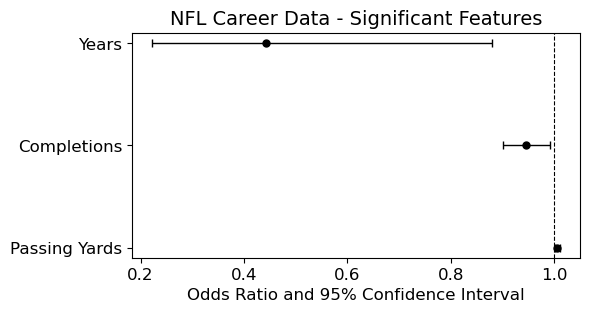

In [89]:
plt.figure(figsize=(6, 3))
odds_sig = odds[odds['Significant?'] == 'Significant']

ci = [odds_sig.iloc[::-1]['Odds Ratio'] - odds_sig.iloc[::-1]['2.5%'].values, odds_sig.iloc[::-1]['97.5%'].values - odds_sig.iloc[::-1]['Odds Ratio']]

plt.errorbar(x=odds_sig.iloc[::-1]['Odds Ratio'], y=odds_sig.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=12)
plt.tight_layout()
plt.title('NFL Career Data - Significant Features', fontsize=14)
plt.show()

### Classification using Seasonal NFL Data

In [90]:
path = 'dataset-quarterback_stats'
filename = 'census.csv'

census = pd.read_csv(os.path.join(path, filename))

In [91]:
path = 'dataset-quarterback_stats/nfl_datasets'
years = list(range(2006, 2022))
league = 'nfl'

dfs = [pd.read_csv(os.path.join(path, league + '_' + str(year) +'.csv')) for year in years]
df = pd.concat(dfs).reset_index(drop=True)
df.fillna(0, inplace=True)
df.head(5)

,Player,Year,Team,Age,Position,Games,Games Started,Wins,Losses,Draws,...,4th Quarter Comeback,Game Winning Drives,Rushing Attempts,Rushing Yards,Rushing TDs,Rushing 1D,Longest Run,Rush Yds/Att,Rush Yds/Game,Fumbles
0,Drew Brees,2006,NOR,27,QB,16,16,10,6,0,...,1.00000,2.00000,42,32,0,5,16,0.80000,2.00000,8
1,Peyton Manning,2006,IND,30,QB,16,16,12,4,0,...,3.00000,3.00000,23,36,4,7,12,1.60000,2.30000,2
2,Marc Bulger,2006,STL,29,QB,16,16,8,8,0,...,2.00000,3.00000,18,44,0,5,29,2.40000,2.80000,6
3,Jon Kitna,2006,DET,34,QB,16,16,3,13,0,...,1.00000,1.00000,34,156,2,9,18,4.60000,9.80000,11
4,Carson Palmer,2006,CIN,27,QB,16,16,8,8,0,...,2.00000,3.00000,26,37,0,6,11,1.40000,2.30000,15


In [92]:
df1 = df[df['Player'].isin(players)].reset_index(drop=True)
df1 = df1.merge(census, how='left', on='Player')
df1

,Player,Year,Team,Age,Position,Games,Games Started,Wins,Losses,Draws,...,Game Winning Drives,Rushing Attempts,Rushing Yards,Rushing TDs,Rushing 1D,Longest Run,Rush Yds/Att,Rush Yds/Game,Fumbles,Race
0,Matt Leinart,2006,ARI,23,QB,12,11,4,7,0,...,1.00000,22,49,2,6,14,2.20000,4.10000,8,White
1,Vince Young,2006,TEN,23,QB,15,13,8,5,0,...,5.00000,83,552,7,32,39,6.70000,36.80000,12,Non-White
2,Brett Basanez,2006,CAR,23,QB,1,0,0,0,0,...,0.00000,1,2,0,0,2,2.00000,2.00000,0,White
3,Vince Young,2007,TEN,24,QB,15,15,9,6,0,...,0.00000,93,395,3,26,21,4.20000,26.30000,10,Non-White
4,Trent Edwards,2007,BUF,24,QB,10,9,5,4,0,...,2.00000,14,49,0,4,14,3.50000,4.90000,4,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,Josh Rosen,2021,ATL,24,QB,4,0,0,0,0,...,0.00000,0,0,0,0,0,0.00000,0.00000,0,White
520,Kellen Mond,2021,MIN,22,QB,1,0,0,0,0,...,0.00000,0,0,0,0,0,0.00000,0.00000,0,Non-White
521,Marcus Mariota,2021,LVR,28,QB,10,0,0,0,0,...,0.00000,13,87,1,6,31,6.70000,8.70000,1,Non-White
522,Feleipe Franks,2021,ATL,24,QB,9,0,0,0,0,...,0.00000,3,6,0,0,4,2.00000,0.70000,0,Non-White


In [93]:
# Split into Training and Test Data
X_train = df1.drop(['Player', 'Year', 'Team', 'Position', 'Race'], axis=1)
y_train = np.asarray(df1['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(524, 37)
(524,)


In [94]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.483415
         Iterations 7


In [95]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  524
Model:                          Logit   Df Residuals:                      487
Method:                           MLE   Df Model:                           36
Date:                Thu, 02 Feb 2023   Pseudo R-squ.:                  0.2240
Time:                        21:45:57   Log-Likelihood:                -253.31
converged:                       True   LL-Null:                       -326.43
Covariance Type:            nonrobust   LLR p-value:                 3.127e-15
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Age                     -0.0286      0.028     -1.030      0.303      -0.083       0.026
Games                    0.0982      0.064      1.533      0.125      -0.027       0.224
Games Starte

In [96]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']

# Convert log odds to Odds Ratios
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['P-Values'] = model.pvalues
odds['Significant?'] = ['Significant' if pval <= 0.05 else 'Not Significant' for pval in model.pvalues]
odds

,2.5%,97.5%,Odds Ratio,P-Values,Significant?
Age,0.92020,1.02622,0.97176,0.30318,Not Significant
Games,0.97304,1.25076,1.10319,0.12522,Not Significant
Games Started,0.06943,1.21654,0.29063,0.09072,Not Significant
Wins,0.89168,15.64026,3.73445,0.07138,Not Significant
Losses,0.82639,14.50605,3.46232,0.08930,Not Significant
Draws,0.49790,26.85670,3.65675,0.20249,Not Significant
Completions,0.96853,1.01916,0.99352,0.61705,Not Significant
Attempts,0.97030,1.00308,0.98655,0.11023,Not Significant
Cmp %,0.97224,1.03219,1.00176,0.90806,Not Significant
Passing Yards,1.00048,1.00442,1.00245,0.01460,Significant


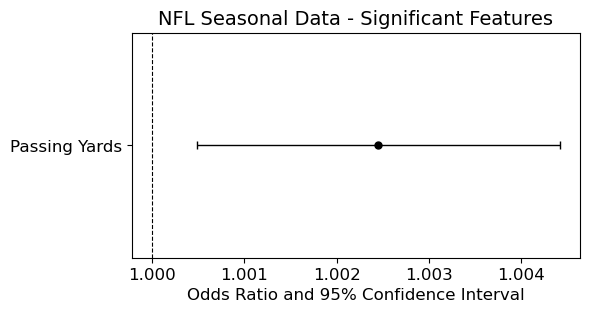

In [97]:
plt.figure(figsize=(6, 3))
odds_sig = odds[odds['Significant?'] == 'Significant']

ci = [odds_sig.iloc[::-1]['Odds Ratio'] - odds_sig.iloc[::-1]['2.5%'].values, odds_sig.iloc[::-1]['97.5%'].values - odds_sig.iloc[::-1]['Odds Ratio']]

plt.errorbar(x=odds_sig.iloc[::-1]['Odds Ratio'], y=odds_sig.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=12)
plt.tight_layout()
plt.title('NFL Seasonal Data - Significant Features', fontsize=14)
plt.show()

### Classification using College Career Data

In [98]:
# Career NFL Data
path = 'dataset-quarterback_stats'
filename = 'cfb_2006-2021.csv'

cfb = pd.read_csv(os.path.join(path, filename))

In [99]:
df2 = cfb[cfb['Player'].isin(players)].reset_index(drop=True)
df2 = df2.merge(census, how='left', on='Player')
df2

,Player,Years,Completions,Attempts,Completion %,Passing Yards,Yds/Att,Adj Yds/Att,Passing TDs,Interceptions,Rating,Rushing Attempts,Rushing Yards,Rush Yds/Att,Rushing TDs,Race
0,Mike White,3,770,1218,0.63000,10179,8.36000,8.71000,71,22,149.04000,122,-427,0.00000,6,White
1,Brandon Weeden,2,751,1076,0.70000,9004,8.37000,8.60000,71,26,157.03000,34,-170,0.00000,1,White
2,Shane Carden,3,1052,1579,0.67000,11991,7.59000,7.83000,86,30,144.59000,271,253,0.00000,24,White
3,Pat White,2,324,490,0.66000,3566,7.28000,7.70000,35,11,146.34000,388,2309,0.00000,22,Non-White
4,JaMarcus Russell,1,232,342,0.68000,3129,9.15000,9.73000,28,8,167.03000,52,142,0.00000,1,Non-White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Hunter Cantwell,1,221,377,0.59000,2493,6.61000,5.55000,16,16,119.68000,39,-115,0.00000,1,White
240,Todd Boeckman,1,191,299,0.64000,2379,7.96000,7.52000,25,14,148.94000,56,63,0.00000,0,White
241,Case Keenum,4,1504,2165,0.69000,18581,8.58000,9.12000,150,41,160.64000,296,826,0.00000,23,White
242,Keith Price,3,738,1146,0.64000,8757,7.64000,7.74000,73,30,144.37000,207,84,0.00000,10,Non-White


In [130]:
# Split into Training and Test Data
X_train = df2.drop(['Player', 'Race', 'Rush Yds/Att'], axis=1)
y_train = np.asarray(df2['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(244, 13)
(244,)


In [131]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.512907
         Iterations 6


In [132]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']

# Convert log odds to Odds Ratios
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['P-Values'] = model.pvalues
odds['Significant?'] = ['Significant' if pval <= 0.05 else 'Not Significant' for pval in model.pvalues]
odds

,2.5%,97.5%,Odds Ratio,P-Values,Significant?
Years,0.34155,2.85060,0.98673,0.98031,Not Significant
Completions,0.98511,1.02092,1.00286,0.75412,Not Significant
Attempts,0.99261,1.00892,1.00073,0.86044,Not Significant
Completion %,0.00000,3603.07257,0.00000,0.13668,Not Significant
Passing Yards,0.99769,1.00116,0.99942,0.51314,Not Significant
Yds/Att,0.07150,8.91868,0.79855,0.85502,Not Significant
Adj Yds/Att,0.02695,6.62662,0.42263,0.53968,Not Significant
Passing TDs,0.91489,1.10001,1.00319,0.94598,Not Significant
Interceptions,0.88912,1.12130,0.99849,0.97959,Not Significant
Rating,0.85372,1.63509,1.18148,0.31443,Not Significant


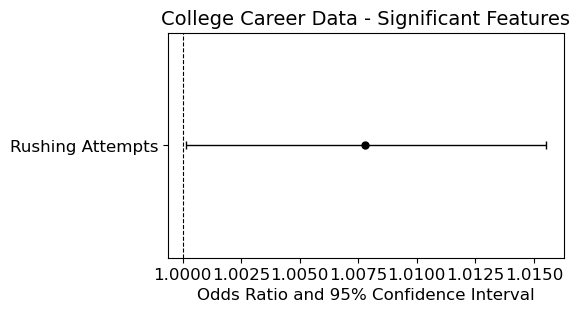

In [133]:
plt.figure(figsize=(6, 3))
odds_sig = odds[odds['Significant?'] == 'Significant']

ci = [odds_sig.iloc[::-1]['Odds Ratio'] - odds_sig.iloc[::-1]['2.5%'].values, odds_sig.iloc[::-1]['97.5%'].values - odds_sig.iloc[::-1]['Odds Ratio']]

plt.errorbar(x=odds_sig.iloc[::-1]['Odds Ratio'], y=odds_sig.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=12)
plt.tight_layout()
plt.title('College Career Data - Significant Features', fontsize=14)
plt.show()

### Classification using College Seasonal Data

In [124]:
path = 'dataset-quarterback_stats/cfb_datasets'
years = list(range(2006, 2022))
league = 'cfb'

dfs = [pd.read_csv(os.path.join(path, league + '_' + str(year) +'.csv')) for year in years]
df = pd.concat(dfs).reset_index(drop=True)
df.fillna(0, inplace=True)
df.head(5)

,Player,School,Conference,Games,Completions,Attempts,Completion %,Passing Yards,Yds/Att,Adj Yds/Att,Passing TDs,Interceptions,Rating,Rushing Attempts,Rushing Yards,Rush Yds/Att,Rushing TDs
0,Colt Brennan,Hawaii,WAC,14,406,559,72.60000,5549,9.90000,11.00000,58,12,186.00000,86,366,4.30000,5
1,Brian Brohm,Louisville,Big East,11,199,313,63.60000,3049,9.70000,10.00000,16,5,159.10000,47,45,1.00000,0
2,John Beck,Brigham Young,MWC,12,289,417,69.30000,3885,9.30000,10.00000,32,8,169.10000,50,-8,-0.20000,6
3,JaMarcus Russell,LSU,SEC,13,232,342,67.80000,3129,9.10000,9.70000,28,8,167.00000,52,142,2.70000,1
4,Jared Zabransky,Boise State,WAC,13,191,288,66.30000,2587,9.00000,9.30000,23,8,162.60000,98,197,2.00000,6


In [125]:
df3 = df[df['Player'].isin(players)].reset_index(drop=True)
df3 = df3.merge(census, how='left', on='Player')
df3

,Player,School,Conference,Games,Completions,Attempts,Completion %,Passing Yards,Yds/Att,Adj Yds/Att,Passing TDs,Interceptions,Rating,Rushing Attempts,Rushing Yards,Rush Yds/Att,Rushing TDs,Race
0,Brian Brohm,Louisville,Big East,11,199,313,63.60000,3049,9.70000,10.00000,16,5,159.10000,47,45,1.00000,0,White
1,John Beck,Brigham Young,MWC,12,289,417,69.30000,3885,9.30000,10.00000,32,8,169.10000,50,-8,-0.20000,6,White
2,JaMarcus Russell,LSU,SEC,13,232,342,67.80000,3129,9.10000,9.70000,28,8,167.00000,52,142,2.70000,1,Non-White
3,Jared Zabransky,Boise State,WAC,13,191,288,66.30000,2587,9.00000,9.30000,23,8,162.60000,98,197,2.00000,6,White
4,Tyler Palko,Pitt,Big East,12,220,322,68.30000,2871,8.90000,9.20000,25,9,163.20000,66,77,1.20000,2,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,Shane Buechele,SMU,American,10,242,370,65.40000,3095,8.40000,8.90000,23,6,152.90000,58,105,1.80000,2,White
556,Ian Book,Notre Dame,ACC,12,228,353,64.60000,2830,8.00000,8.50000,15,3,144.30000,116,485,4.20000,9,White
557,Sam Ehlinger,Texas,Big 12,10,194,322,60.20000,2566,8.00000,8.90000,26,5,150.70000,113,377,3.30000,8,White
558,Kellen Mond,Texas A&M,SEC,10,188,297,63.30000,2282,7.70000,8.50000,19,3,146.90000,74,294,4.00000,4,Non-White


In [126]:
# Split into Training and Test Data
X_train = df3.drop(['Player', 'Race', 'School', 'Conference'], axis=1)
y_train = np.asarray(df3['Race'].map({'White':0, 'Non-White':1}))

print(X_train.shape)
print(y_train.shape)

(560, 14)
(560,)


In [127]:
model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.509984
         Iterations 6


In [128]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']

# Convert log odds to Odds Ratios
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['P-Values'] = model.pvalues
odds['Significant?'] = ['Significant' if pval <= 0.05 else 'Not Significant' for pval in model.pvalues]
odds

,2.5%,97.5%,Odds Ratio,P-Values,Significant?
Games,0.81103,1.19267,0.98351,0.86576,Not Significant
Completions,0.97654,1.05162,1.01338,0.48170,Not Significant
Attempts,0.98835,1.00902,0.99863,0.79556,Not Significant
Completion %,0.70613,1.55279,1.04713,0.81882,Not Significant
Passing Yards,0.99401,1.00083,0.99742,0.13806,Not Significant
Yds/Att,0.31245,22.94508,2.67752,0.36888,Not Significant
Adj Yds/Att,0.13852,53.34926,2.71844,0.51025,Not Significant
Passing TDs,0.93671,1.39818,1.14442,0.18679,Not Significant
Interceptions,0.84931,1.33380,1.06434,0.58816,Not Significant
Rating,0.60716,1.25231,0.87198,0.45825,Not Significant


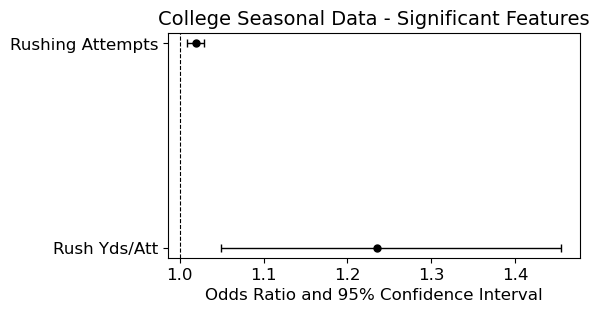

In [129]:
plt.figure(figsize=(6, 3))
odds_sig = odds[odds['Significant?'] == 'Significant']

ci = [odds_sig.iloc[::-1]['Odds Ratio'] - odds_sig.iloc[::-1]['2.5%'].values, odds_sig.iloc[::-1]['97.5%'].values - odds_sig.iloc[::-1]['Odds Ratio']]

plt.errorbar(x=odds_sig.iloc[::-1]['Odds Ratio'], y=odds_sig.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=12)
plt.tight_layout()
plt.title('College Seasonal Data - Significant Features', fontsize=14)
plt.show()